In [1]:
import Processor
from CensusMethods import *
from MapGenerator import *

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import plotnine 
import yaml
import requests
import json
import config

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px

from us import states
from plotnine import *
from urllib.request import urlopen
from shapely.geometry import Point, Polygon
from pyproj import Transformer

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
def load_creds_yaml(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream) 
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

def load_creds_json(path: str):
    with open(path, "r") as file:
        return json.load(file)

def string_to_tuple(string):
    string = string[1:-1]
    return tuple(map(np.float64, string.split(', ')))

try:
    creds = load_creds_yaml("cred.yml")
except:
    creds = load_creds_json("../config.json")

In [6]:
vars_to_retrieve = ['B01003_001E','B03002_012E','B03002_003E',
                                    'B03002_004E','B03002_005E','B03002_006E','B03002_007E',
                                    'B03002_008E','B03002_009E']

c = CensusMethods(creds["CENSUS"]["API_KEY"])
c.retrieve_all_variables()
relevant_values = c.retrieve_subset_of_variables(vars_to_retrieve)

relevant_values['label2'] = ['total_pop','hispanic','white','black',
                             'native_american','asian','pacific_islander','some_other_race','multi_race']

In [7]:
# retrieve census data for states
string_format_list = input("Enter state abbreviations for states you want data for, comma separated.")
list_of_states = [s.upper().strip() for s in string_format_list.split(",")]

census_data_dict = c.retrieve_census_data_for_list_of_states_by_year(tuple(["NAME"] + vars_to_retrieve), list_of_states, "*", "*", 2019)

Enter state abbreviations for states you want data for, comma separated.VA


In [8]:
state_dfs = {state: pd.DataFrame(census_data_dict[state]) for state in census_data_dict.keys()}
geocoded_state_dfs = {state: c.create_geocoded_state_df_with_demographics_data(state, state_dfs[state]) 
                      for state in state_dfs.keys()}

In [10]:
subseted_geocoded_dfs_tract_level = {state: geocoded_state_dfs[state]
                         [["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry",'non_white_percentage']] 
                         for state in geocoded_state_dfs}

subseted_geocoded_dfs_county_level = {state: subseted_geocoded_dfs_tract_level[state]\
                                      .dissolve(by = "COUNTYFP", aggfunc = "sum") for state in subseted_geocoded_dfs_tract_level}

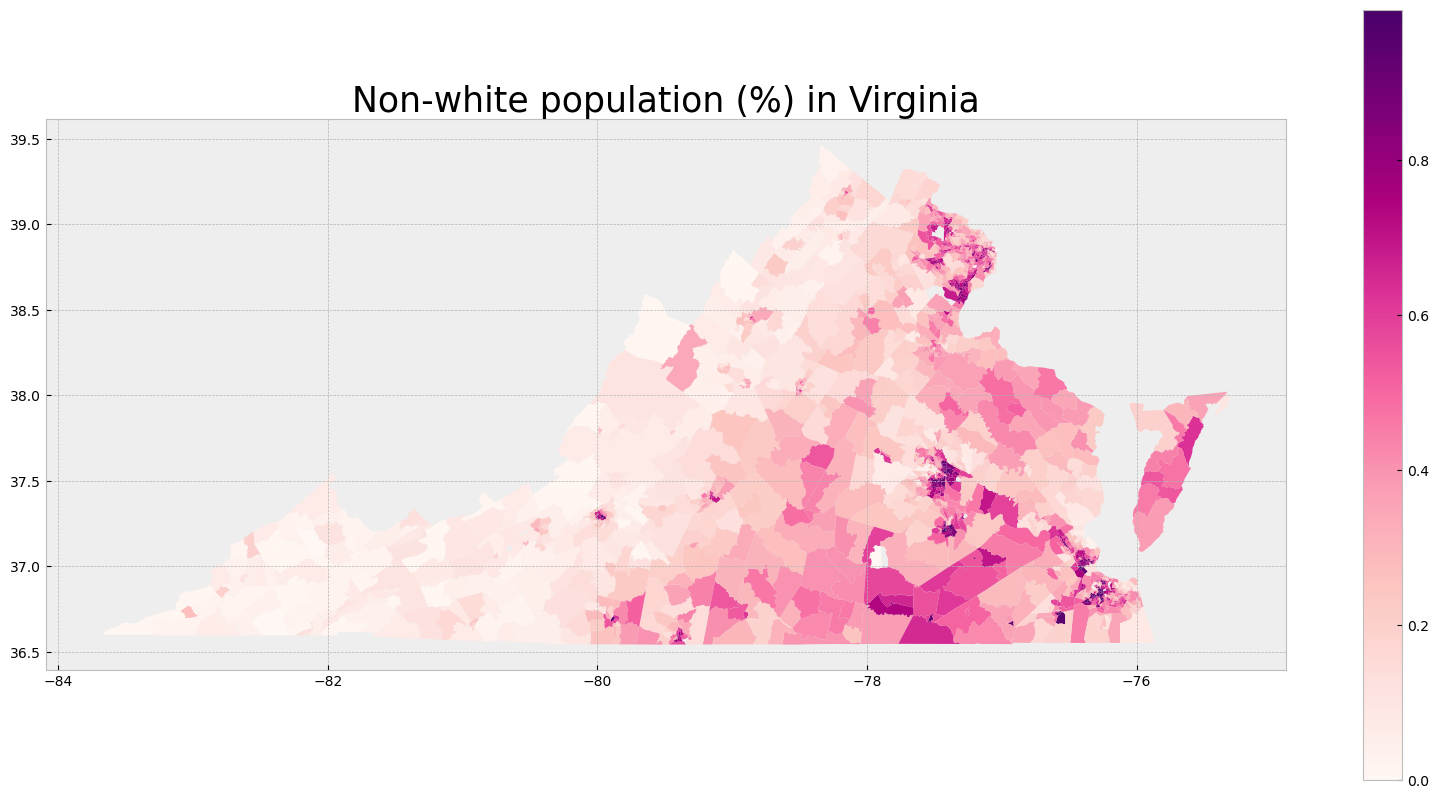

In [12]:
for state in subseted_geocoded_dfs_tract_level:
    MapGenerator.create_nonwhite_population_plot_for_state(subseted_geocoded_dfs_tract_level[state], state)

In [30]:
full_us_data = c.retrieve_census_data_for_list_of_states_by_year(tuple(vars_to_retrieve), 
                                                                 [state.abbr for state in states.STATES], "*", "*", 2019)
census = pd.concat([pd.DataFrame(full_us_data[state]) for state in full_us_data])
d0 = relevant_values['label2']
d = d0.to_dict()
d.update({'state':'state','county':'county','tract':'tract'})
census = census.rename(columns=d)
census.head()

,total_pop,hispanic,white,black,native_american,asian,pacific_islander,some_other_race,multi_race,state,county,tract
0,4781.0,17.0,77.0,4629.0,58.0,0.0,0.0,0.0,0.0,01,073,001100
1,1946.0,133.0,0.0,1784.0,0.0,0.0,0.0,22.0,7.0,01,073,001400
2,4080.0,306.0,1132.0,2604.0,0.0,0.0,0.0,0.0,38.0,01,073,002000
3,5291.0,0.0,85.0,5161.0,0.0,0.0,0.0,0.0,45.0,01,073,003802
4,2533.0,173.0,167.0,2171.0,22.0,0.0,0.0,0.0,0.0,01,073,004000


In [41]:
tract_q_base = c.retrieve_census_tract_shapefile_for_state_list([state.abbr for state in states.STATES])

In [42]:
us_tract = tract_q_base.to_crs(epsg = 4326)

In [43]:
census = c.create_population_columns(census)